In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt


In [2]:
import random

def set_random_seed(seed_value):
    """Set the random seed for reproducibility."""
    random.seed(seed_value)  # Set the seed for Python's random module
    np.random.seed(seed_value)  # Set the seed for NumPy
    torch.manual_seed(seed_value)  # Set the seed for PyTorch CPU
    torch.cuda.manual_seed(seed_value)  # Set the seed for PyTorch GPU (if using)
    torch.cuda.manual_seed_all(seed_value)  # Set the seed for all GPUs (if using)
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior on GPU
    torch.backends.cudnn.benchmark = False  # Turn off benchmarks for reproducibility

# Set a specific random seed value (e.g., 42)
set_random_seed(42)

In [3]:
# Load the data
def load_data():
    reviews = pd.read_pickle('../Pickle/reviews.pkl')
    books = pd.read_pickle('../Pickle/books.pkl')
    read = pd.read_pickle('../Pickle/read.pkl')
    user_genres = pd.read_pickle('../Pickle/user_most_common_genres.pkl')
    review_embeddings = pd.read_pickle('../Pickle/review_embeddings.pkl')
    review_sentiment = pd.read_pickle('../Pickle/review_score.pkl')
    return reviews, books, read, user_genres, review_embeddings, review_sentiment

In [4]:
# Initialize ID mappings for users and books
def initialize_id_mappings(combined_data):
    unique_user_ids = set(combined_data['user_id'])
    unique_book_ids = set(combined_data['book_id'])

    user_id_to_index = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
    book_id_to_index = {book_id: idx for idx, book_id in enumerate(unique_book_ids)}

    return user_id_to_index, book_id_to_index

In [5]:
def filter_and_split_data(ratings_data, user_genres, test_size=0.2, random_state=42):
    # Filter out books that have been rated fewer than twice
    book_user_counts = ratings_data['book_id'].value_counts()
    eligible_books = book_user_counts[book_user_counts > 5].index  
    ratings_data = ratings_data[ratings_data['book_id'].isin(eligible_books)]

    # Filter out users who don't have enough ratings
    user_book_counts = ratings_data['user_id'].value_counts()
    eligible_users = user_book_counts[user_book_counts > 5].index  
    ratings_data = ratings_data[ratings_data['user_id'].isin(eligible_users)]    

    # Ensure users are in both ratings_data and user_genres
    eligible_users_in_genres = user_genres['user_id'].isin(eligible_users)
    user_genres = user_genres[eligible_users_in_genres]
    
    # Merge the ratings_data and user_genres on user_id to get the most common genres for users
    filtered_data = ratings_data.merge(user_genres[['user_id', 'most_common_genres']], on='user_id', how='inner')

    # Now proceed with train-test split
    train_dfs = []
    test_dfs = []

    # Create a mask to check for users with enough rated books (>= 5)
    user_data_valid = filtered_data.groupby('user_id').filter(lambda x: len(x) > 5)

    # Split train-test for each user
    for user_id, user_data in user_data_valid.groupby('user_id'):
        books = user_data['book_id'].unique()  # All books rated by the user
        
        # Split the books into train and test sets
        train_books, test_books = train_test_split(books, test_size=test_size, random_state=random_state)
        
        # Get the train and test data for the user
        user_train_data = user_data[user_data['book_id'].isin(train_books)]
        user_test_data = user_data[user_data['book_id'].isin(test_books)]
        
        # Append to train and test lists
        train_dfs.append(user_train_data)
        test_dfs.append(user_test_data)
    
    # Combine all the train and test data into single dataframes
    train_data = pd.concat(train_dfs)
    test_data = pd.concat(test_dfs)

    return train_data, test_data, user_genres, filtered_data

In [6]:
# Log scale ratings
def normalize_ratings(train_data, test_data):
    min_rating = train_data['rating'].min()
    
    if min_rating < 0:
        train_data['rating'] = train_data['rating'] - min_rating
        test_data['rating'] = test_data['rating'] - min_rating

    train_data['rating'] = np.log1p(train_data['rating'])
    test_data['rating'] = np.log1p(test_data['rating'])

    return train_data, test_data, min_rating


def denormalize_rating(log_scaled_ratings, min_rating=0):
    # Reverse log1p (i.e., exp(x) - 1)
    original_ratings = np.expm1(log_scaled_ratings)
    
    if min_rating != 0:
        original_ratings += min_rating
        
    return np.clip(original_ratings, 0, 5)


In [7]:
import pandas as pd
from sklearn.utils import resample

def balance_ratings(train_data):
    # Get the value counts of the rating column
    rating_counts = train_data['rating'].value_counts()

    # Find the target number of samples for balancing (median of class counts)
    target_count = 12000

    # Separate the data by ratings
    balanced_data = []

    for rating, count in rating_counts.items():
        rating_data = train_data[train_data['rating'] == rating]
        
        if count > target_count:
            # Under-sample if the class has more samples than the target
            rating_data = resample(rating_data, 
                                   replace=False, 
                                   n_samples=target_count, 
                                   random_state=42)
        elif count < target_count:
            # Over-sample if the class has fewer samples than the target
            rating_data = resample(rating_data, 
                                   replace=True, 
                                   n_samples=target_count, 
                                   random_state=42)

        # Add the balanced data for this rating to the list
        balanced_data.append(rating_data)

    # Combine all the balanced data
    balanced_train_data = pd.concat(balanced_data, axis=0)

    # Shuffle the dataset to mix the over-sampled and under-sampled data
    balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_train_data


In [8]:
import torch
import numpy as np

def prepare_edge_index_ratings_attributes(df, user_id_to_index, book_id_to_index):
    # Map user and book IDs to indices
    user_indices = df['user_id'].map(user_id_to_index).dropna().astype(int).values
    book_indices = df['book_id'].map(book_id_to_index).dropna().astype(int).values

    # Ensure valid mappings
    valid_mask = (user_indices >= 0) & (book_indices >= 0)
    user_indices = user_indices[valid_mask]
    book_indices = book_indices[valid_mask]

    # Create edge index
    edge_index = torch.tensor([user_indices, book_indices], dtype=torch.long)

    # Convert ratings and confidence scores to tensors
    ratings_tensor = torch.tensor(df.loc[valid_mask, 'rating'].values, dtype=torch.float32).view(-1, 1)
    confidence_tensor = torch.tensor(df.loc[valid_mask, 'confidence_score'].values, dtype=torch.float32).view(-1, 1)

    # Efficiently convert list of NumPy arrays to a tensor
    embeddings_np = np.stack(df.loc[valid_mask, 'embeddings'].values)  # Stack directly
    embeddings_tensor = torch.from_numpy(embeddings_np).float()  # Convert efficiently

    # Concatenate ratings, confidence scores, and embeddings into a single edge attribute tensor
    edge_attr = torch.cat([ratings_tensor, confidence_tensor, embeddings_tensor], dim=1)

    return edge_index, edge_attr


In [9]:
def align_user_and_book_features(filtered_data, user_id_to_index, book_id_to_index):
    # Create a dictionary for all possible genres (book genres from filtered data)
    unique_book_genres = sorted(set(filtered_data['filtered_genres'].str.split(',').explode()))
    book_genre_dict = {genre: idx for idx, genre in enumerate(unique_book_genres)}

    # Prepare user genre features
    user_genre_features = {}
    
    # Group by user_id and process all genres at once
    for user_id, group in filtered_data.groupby('user_id'):
        genres = group['most_common_genres'].iloc[0]  # All rows for this user should have the same genres
        genre_vector = np.zeros(len(book_genre_dict))  # Size based on unique book genres
        for genre in genres:
            if genre in book_genre_dict:
                genre_vector[book_genre_dict[genre]] = 1
        user_genre_features[user_id_to_index[user_id]] = torch.tensor(genre_vector, dtype=torch.float32)

    # Prepare book genre features
    book_genre_features = {}
    for book_id, group in filtered_data.groupby('book_id'):
        genres = group['filtered_genres'].iloc[0].split(',')  # Assuming all rows for this book have the same genres
        genre_vector = np.zeros(len(book_genre_dict))  # Size based on unique book genres
        for genre in genres:
            if genre in book_genre_dict:
                genre_vector[book_genre_dict[genre]] = 1
        book_genre_features[book_id_to_index[book_id]] = torch.tensor(genre_vector, dtype=torch.float32)

    return user_genre_features, book_genre_features

In [10]:
from sklearn.decomposition import PCA

def apply_pca_on_features(user_genre_features, book_genre_features, n_components=5):
    # Combine user and book features into one array for PCA
    all_user_features = torch.stack(list(user_genre_features.values()))
    all_book_features = torch.stack(list(book_genre_features.values()))

    all_features = torch.cat([all_user_features, all_book_features], dim=0)  # Combine user and book features

    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(all_features)

    # Split back the reduced features into user and book features
    reduced_user_features = reduced_features[:len(user_genre_features)]
    reduced_book_features = reduced_features[len(user_genre_features):]

    # Update the user and book genre features dictionaries with the reduced features
    updated_user_genre_features = {key: torch.tensor(val) for key, val in zip(user_genre_features.keys(), reduced_user_features)}
    updated_book_genre_features = {key: torch.tensor(val) for key, val in zip(book_genre_features.keys(), reduced_book_features)}

    return updated_user_genre_features, updated_book_genre_features

In [11]:
import torch
import numpy as np
from torch_geometric.data import Data

def prepare_data_objects(train_data, test_data, user_genre_features, book_genre_features, user_id_to_index, book_id_to_index):
    train_edge_index, train_edge_attr = prepare_edge_index_ratings_attributes(
        train_data, user_id_to_index, book_id_to_index
    )
    test_edge_index, test_edge_attr = prepare_edge_index_ratings_attributes(
        test_data, user_id_to_index, book_id_to_index
    )

    # Convert user and book genre features efficiently
    user_embeddings = torch.from_numpy(np.stack(list(user_genre_features.values()))).float()
    book_embeddings = torch.from_numpy(np.stack(list(book_genre_features.values()))).float()

    # Combine user and book embeddings into node features
    node_embeddings = torch.cat([user_embeddings, book_embeddings], dim=0)

    # Ensure edge_index is correctly formatted
    train_edge_index = train_edge_index.clone().detach()  # Ensure it's a tensor
    test_edge_index = test_edge_index.clone().detach()

    # Create PyG Data objects
    train_data_obj = Data(
        x=node_embeddings,
        edge_index=train_edge_index,
        edge_attr=train_edge_attr  
    )
    
    test_data_obj = Data(
        x=node_embeddings,
        edge_index=test_edge_index,
        edge_attr=test_edge_attr
    )

    return train_data_obj, test_data_obj


In [12]:
reviews, books, read, user_genres, review_embeddings, review_sentiment = load_data()

In [13]:
reviews = pd.merge(reviews, review_embeddings, on="review_id", how="inner")  
reviews = pd.merge(reviews, review_sentiment, on="review_id", how="inner") 
reviews  = reviews[['rating', 'user_id', 'book_id', 'confidence_score', 'embeddings']]   
books = books[['book_id', 'title', 'authors', 'filtered_genres', 'average_rating']]
data = pd.merge(books, reviews, on='book_id', how='inner')
data = data.reset_index(drop=True)
user_genres = user_genres.reset_index()
user_genres = user_genres[user_genres['most_common_genres'].apply(lambda x: len(x) > 0)]


In [14]:
#Compute the average rating per user (excluding 0s) and round to the nearest whole number
user_avg_rating = data[data['rating'] > 0].groupby('user_id')['rating'].mean().round().astype(int)

#Round the book's average rating column
data['average_rating'] = pd.to_numeric(data['average_rating'], errors='coerce').round().astype('Int64')

#Replace 0 ratings with the user's average rating or the book's average rating if the user has no ratings
def impute_rating(row):
    if row['rating'] == 0:
        return user_avg_rating.get(row['user_id'], row['average_rating'])  # Use user avg or book avg
    return row['rating']

# Apply the function
data['rating'] = data.apply(impute_rating, axis=1)


In [15]:
train_data, test_data, user_genres, filtered_data = filter_and_split_data(data, user_genres)

In [16]:
user_id_to_index, book_id_to_index = initialize_id_mappings(filtered_data)

In [17]:
train_data = balance_ratings(train_data)

In [18]:
train_data, test_data, min_rating = normalize_ratings(train_data, test_data)

In [19]:
user_genre_features, book_genre_features = align_user_and_book_features(filtered_data, user_id_to_index, book_id_to_index)

In [20]:
train_data_obj, test_data_obj = prepare_data_objects(
    train_data, test_data, user_genre_features, book_genre_features, user_id_to_index, book_id_to_index
)

C:\Users\maddy\AppData\Local\Temp\ipykernel_14684\2194053185.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\torch\csrc\utils\tensor_new.cpp:277.)
  edge_index = torch.tensor([user_indices, book_indices], dtype=torch.long)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import torch.nn as nn

class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads, edge_feature_dim):
        super(GATModel, self).__init__()
        self.gat1 = GATv2Conv(in_channels, hidden_channels, heads=num_heads)
        self.gat2 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads)
        self.gat3 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads)
        self.gat4 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads)
        self.gat5 = GATv2Conv(hidden_channels * num_heads, out_channels, heads=num_heads, concat=False)

        # Linear layer to process edge attributes
        self.edge_mlp = nn.Linear(edge_feature_dim, hidden_channels)

    def forward(self, x, edge_index, edge_attr):
        # Process edge attributes with an MLP
        edge_attr = self.edge_mlp(edge_attr)
        edge_attr = F.elu(edge_attr)

        # Pass through the GAT layers
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.gat3(x, edge_index)
        x = F.elu(x)
        x = self.gat4(x, edge_index)
        x = F.elu(x)
        x = self.gat5(x, edge_index)

        # Compute edge outputs using node embeddings + processed edge features
        edge_outputs = torch.sum(x[edge_index[0]] * x[edge_index[1]], dim=-1)
        edge_outputs = edge_outputs + torch.sum(edge_attr, dim=-1)  # Add edge features

        return edge_outputs


    def predict(self, x, edge_index, edge_attr):
        """Prediction method for making predictions on new data."""
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for inference
            return self.forward(x, edge_index, edge_attr)


all_embeddings = train_data['embeddings'].tolist() + test_data['embeddings'].tolist()

# Convert to NumPy array to ensure consistency
all_embeddings = np.array(all_embeddings, dtype=object)  

# Get the size of the first valid embedding
embedding_size = len(all_embeddings[0])
edge_feature_dim = 1 + 1 + embedding_size  # Rating + Confidence + Embedding Size

# Initialize the GAT model with the correct edge feature dimension
model = GATModel(
    in_channels=train_data_obj.x.shape[1],  # Input features per node
    hidden_channels=30,
    out_channels=1,
    num_heads=30,
    edge_feature_dim=edge_feature_dim  # Correct edge feature dimension
)

In [36]:
def plot_predictions(predictions, true_values):
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, predictions, alpha=0.5, color='blue', label="Predictions vs True")
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', label='Perfect Prediction')
    plt.xlabel('True Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('Predicted Ratings vs True Ratings')
    plt.legend()
    plt.show()

In [37]:
from torch_geometric.loader import DataLoader 
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_data_list = [train_data_obj]  # List of data objects for training
test_data_list = [test_data_obj]    # List of data objects for testing

# Create DataLoader for training and testing
train_loader = DataLoader(train_data_list, batch_size=8, shuffle=True)  # Adjust batch_size as needed
test_loader = DataLoader(test_data_list, batch_size=8, shuffle=False)

def train_gat(model, train_loader, test_loader, num_epochs, lr):
    optimizer = optim.AdamW(model.parameters(), lr=lr)  # Adam optimizer
    criterion = nn.MSELoss()  # Mean Squared Error loss for rating prediction

    all_true_values = []  # To store true values
    all_predicted_values = []  # To store predicted values

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        optimizer.zero_grad()  # Zero the gradients at the start of each epoch

        # Training loss calculation
        total_train_loss = 0
        num_train_batches = 0

        # Iterate over batches in the train_loader
        for batch in train_loader:
            batch = batch.to(device)  # Move to device
            optimizer.zero_grad()

            # Forward pass
            out = model(batch.x, batch.edge_index, batch.edge_attr)  # Output should be of shape [num_edges, 1]
            out = out.view(-1, 1)  # Reshape the output to match the target shape

            # Ensure target is reshaped correctly
            target = batch.edge_attr[:, 0].view(-1, 1)  # Select only the rating part

            # Store true and predicted values for plotting later
            all_true_values.extend(target.cpu().numpy())  # Move to CPU for plotting
            all_predicted_values.extend(out.cpu().detach().numpy())  # Move to CPU and detach gradients

            # Loss calculation
            loss = criterion(out, target)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            num_train_batches += 1

        # Calculate and log the average training loss for the epoch
        average_train_loss = total_train_loss / num_train_batches
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss:.4f}')

        # Evaluate the model on test data after each epoch
        model.eval()
        total_test_loss = 0
        num_test_batches = 0
        with torch.no_grad():  
            for batch in test_loader:
                batch = batch.to(device)

                test_out = model(batch.x, batch.edge_index, batch.edge_attr)

                # Ensure the test output is reshaped correctly
                test_out = test_out.view(-1, 1)

                # Ensure target is reshaped correctly for the test batch
                target = batch.edge_attr[:, 0].view(-1, 1)

                # Loss calculation for test data
                test_loss = criterion(test_out, target)
                total_test_loss += test_loss.item()
                num_test_batches += 1

        # Calculate and log the average test loss for the epoch
        average_test_loss = total_test_loss / num_test_batches
        print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {average_test_loss:.4f}')

    # After all epochs, plot the predictions
    plot_predictions(all_true_values, all_predicted_values)

    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_true = []

    with torch.no_grad(): 
        for batch in test_loader:
            batch = batch.to(device)  # Move to device

            # Forward pass for test data
            test_out = model(batch.x, batch.edge_index, batch.edge_attr)

            # Ensure the test output is reshaped correctly
            test_out = test_out.view(-1, 1)

            # Ensure target is reshaped correctly for the test batch
            target = batch.edge_attr[:, 0].view(-1, 1)

            all_preds.append(test_out)
            all_true.append(target)

    # Concatenate all predictions and true values
    all_preds = torch.cat(all_preds, dim=0)
    all_true = torch.cat(all_true, dim=0)

    # Convert predictions and targets to numpy arrays for scikit-learn 
    all_preds = all_preds.cpu().numpy()
    all_true = all_true.cpu().numpy()

    # Regression metrics (MSE and MAE)
    mse = mean_squared_error(all_true, all_preds)
    mae = mean_absolute_error(all_true, all_preds)

    # Print regression metrics
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    torch.save(model.state_dict(), 'gat_model.pth')
    print("Model saved successfully!")


In [ ]:
train_gat(model, train_loader, test_loader, num_epochs=100, lr=0.001)

Epoch 1/100, Training Loss: 1.2379
Epoch 1/100, Test Loss: 82.9677
Epoch 2/100, Training Loss: 88.2672
Epoch 2/100, Test Loss: 19.0004
Epoch 3/100, Training Loss: 16.8218
Epoch 3/100, Test Loss: 139.9010
Epoch 4/100, Training Loss: 147.7283
Epoch 4/100, Test Loss: 6379.2637
Epoch 5/100, Training Loss: 6433.6680
Epoch 5/100, Test Loss: 25.5752
Epoch 6/100, Training Loss: 22.8958
Epoch 6/100, Test Loss: 10.0675
Epoch 7/100, Training Loss: 12.1371
Epoch 7/100, Test Loss: 3.6554
Epoch 8/100, Training Loss: 2.8746
Epoch 8/100, Test Loss: 38.0342
Epoch 9/100, Training Loss: 34.6964
Epoch 9/100, Test Loss: 39.6952
Epoch 10/100, Training Loss: 36.2935
Epoch 10/100, Test Loss: 1.6452
Epoch 11/100, Training Loss: 1.4309
Epoch 11/100, Test Loss: 121.0327
Epoch 12/100, Training Loss: 128.6244
Epoch 12/100, Test Loss: 3.9933
Epoch 13/100, Training Loss: 5.3099
Epoch 13/100, Test Loss: 21.0488
Epoch 14/100, Training Loss: 18.5984
Epoch 14/100, Test Loss: 41.4890
Epoch 15/100, Training Loss: 37.9186


In [25]:
predictions = model.predict(test_data_obj.x, test_data_obj.edge_index, test_data_obj.edge_attr)

In [26]:
predictions = denormalize_rating(predictions, min_rating)

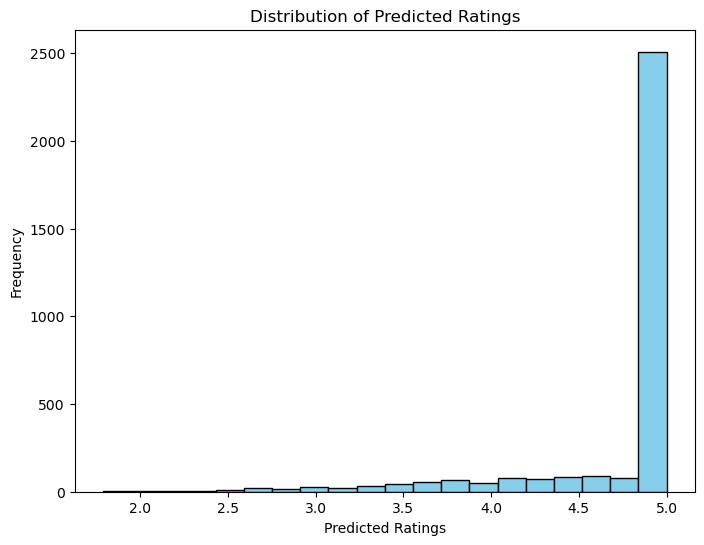

In [27]:
import matplotlib.pyplot as plt

def plot_prediction_histogram(predictions):
    plt.figure(figsize=(8, 6))
    plt.hist(predictions, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Predicted Ratings')
    plt.xlabel('Predicted Ratings')
    plt.ylabel('Frequency')
    plt.show()

plot_prediction_histogram(predictions)

In [28]:
predictions.min().item()

1.7887378931045532

In [29]:
predictions.max().item()

5.0

In [30]:
predictions.mean()

tensor(4.7562)

In [31]:
data['rating'].mean()

3.929838937552981

In [32]:
from sklearn.cluster import KMeans

def visualize_embeddings_with_clustering(data_obj, embed_type="node", n_clusters=6):
    if embed_type == "node":
        embeddings = data_obj.x.cpu().detach().numpy()
        title = "PCA of Node Embeddings with Clusters"
    else:
        embeddings = data_obj.edge_attr.cpu().detach().numpy()
        title = "t-SNE of Edge Embeddings with Clusters"

    if embeddings.shape[1] > 2:  # Apply dimensionality reduction if needed
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
    else:
        reduced_embeddings = embeddings

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reduced_embeddings)
    labels = kmeans.labels_

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.7)
    
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.colorbar(label="Cluster")
    plt.show()


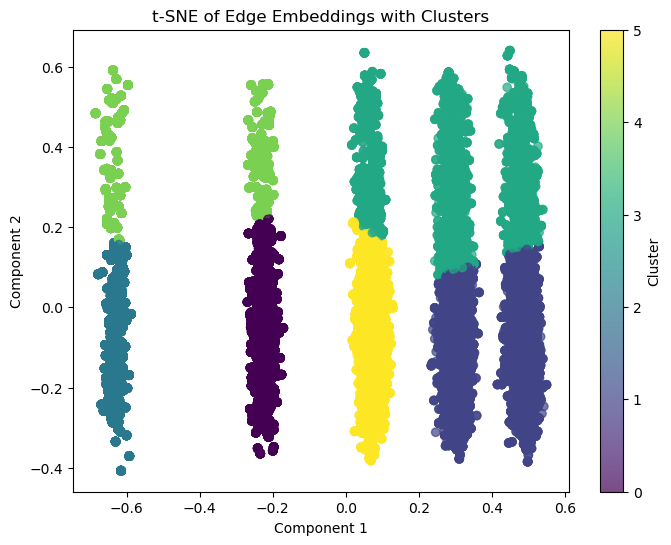

In [33]:
visualize_embeddings_with_clustering(train_data_obj, embed_type="edge")

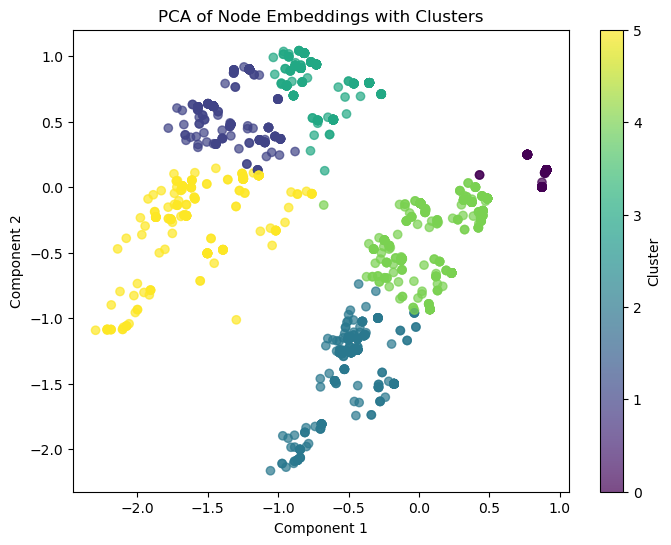

In [34]:
visualize_embeddings_with_clustering(train_data_obj, embed_type="node")